In [19]:
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mape
from darts.models import TransformerModel

import pandas as pd
from pathlib import Path
import os
# from src_transformers.preprocessing.multi_symbol_dataset import MultiSymbolDataset

In [20]:
file_path = Path(os.getcwd()).parents[0]
file_path = Path(file_path, "data", "input", "us3000_tickers_A-B_1min_iqksn", "AAPL_1min.txt")
print(file_path.absolute())

dataset = pd.read_csv(file_path, names=["Date", "Open", "High", "Low", "Close", "Volume"])
dataset.info()

c:\Users\lucan\Documents\Git Projects\Deep_Learning\data\input\us3000_tickers_A-B_1min_iqksn\AAPL_1min.txt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655629 entries, 0 to 2655628
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 121.6+ MB


In [21]:
dataset = dataset[["Date","Close"]]
dataset["Date"] = pd.to_datetime(dataset["Date"], format="%Y-%m-%d %H:%M:%S")
dataset = dataset.iloc[::15]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177042 entries, 0 to 2655615
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    177042 non-null  datetime64[ns]
 1   Close   177042 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.7 MB


In [22]:
dataset = dataset.ffill().bfill()
dataset["Close"] = dataset["Close"].pct_change(fill_method=None)

<Axes: xlabel='Date'>

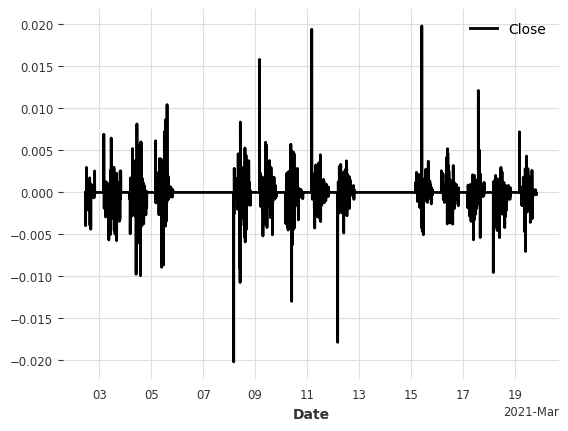

In [23]:
dataset = TimeSeries.from_dataframe(dataset, time_col="Date", freq="T", fill_missing_dates=True, fillna_value=0)
dataset = dataset.tail(25000)
dataset.plot()

<Axes: xlabel='Date'>

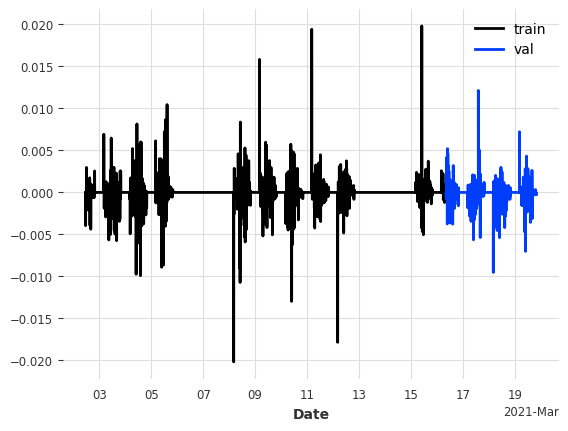

In [24]:
train, val = dataset.split_after(0.8)
train.plot(label="train")
val.plot(label="val")

In [25]:
my_model = TransformerModel(
    input_chunk_length=50,
    output_chunk_length=1,
    batch_size=1024,
    n_epochs=20,
    model_name="single_aktie",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    log_tensorboard=True,
    work_dir="../runs"
)

In [26]:
my_model.fit(series=train, val_series=val, verbose=True)

c:\Users\lucan\.conda\envs\dl2\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer    

Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\lucan\.conda\envs\dl2\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s, v_num=logs, train_loss=8.21e-5, val_loss=3e-6]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s, v_num=logs, train_loss=8.21e-5, val_loss=3e-6]


TransformerModel(d_model=16, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=50, output_chunk_length=1, batch_size=1024, n_epochs=20, model_name=single_aktie, nr_epochs_val_period=10, random_state=42, save_checkpoints=True, log_tensorboard=True, work_dir=../runs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:27<00:00,  0.04it/s]


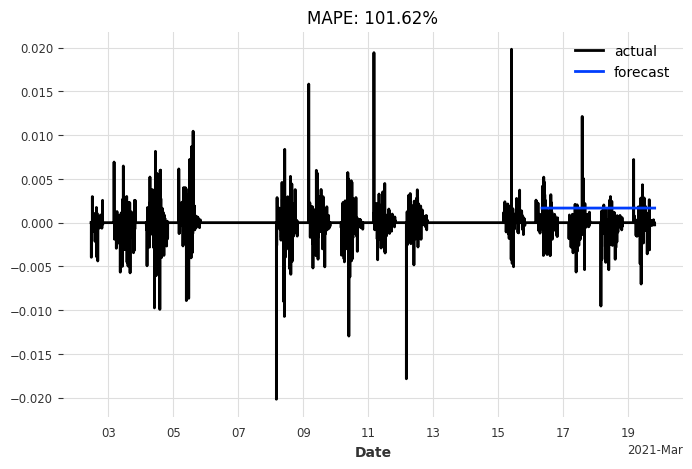

In [27]:
def eval_model(model, series, val_series):
    pred_series = model.predict(n=len(val_series))
    plt.figure(figsize=(8, 5))

    series.plot(label="actual")
    pred_series.plot(label="forecast")

    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))

    plt.legend()
    plt.show()


eval_model(my_model, dataset, val)